# **SVHN Dataset**
In the following exercices, you will work with the SVHN dataset: http://ufldl.stanford.edu/housenumbers/

It contains RGB images of street digits labeled from 1 to 10 similar to the MNIST dataset.

The train and test sets are provided in the folder Data/svhn/ in .mat format.
In the following we show an example of how to load the images and labels from these files. A DataLoader for this dataset is provided in the code examples for the lab.

Mounted at /content/drive
Label: 1


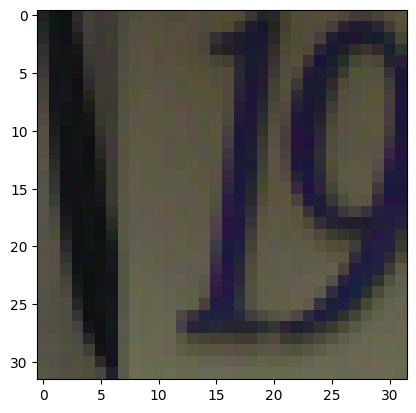

In [ ]:
# Basic example loading images from the svhn dataset
import scipy.io as sio
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
# Mount Google Drive
drive.mount('/content/drive')
data_path = '/content/drive/My Drive/DeepLearning_2023/P3/Data/'
results_path = '/content/drive/My Drive/DeepLearning_2023/P3/Results/'

# Load mat file with train images from SVHN
import scipy.io as sio
train_mat = sio.loadmat(data_path + 'svhn/train_32x32.mat')

images = train_mat['X']
labels = train_mat['y'].squeeze()

example_image, example_label = images[:,:,:,0], labels[0] 

print('Label: ' + str(example_label))
plt.imshow(example_image)

In [ ]:
n_images = images.shape[3] 
print('number of images: ', n_images)

number of images:  73257


# Ex. 1


'''
1. Try to obtain the maximum test accuracy possible in the SVHN dataset. For this purpose train/test different variants of the CNN provided in P3-Part1-Examples.
   You can explore different strategies:
1.1. Increase the size of the network by adding one ore more conv. layers. You can also increase the number of filters in each layer.
1.2. Try different optimizers such as Adam or SGD with momentum and modify the learning rate. You can check: https://pytorch.org/docs/stable/optim.html
1.3. Explore different random transformations during training ( Data augmentation ) such as random cropping with padding. 
You can check: https://pytorch.org/docs/stable/torchvision/transforms.html . Remember that these random transofrmation must not be used during testing.
1.4 Whatever you consider...


2. Save all the different models , compare their test accuracy and analyse the results. Discuss what model has been shown more effective and why have you used the different strategies.
'''

# Sol. 1

## SVHN Dataset and DataLoader

In [ ]:
## Create SVHN database

# All the data will be loaded from the provided file in Data/mnist.t
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as tf
import matplotlib.pyplot as plt
from PIL import Image
import scipy.io as sio
from google.colab import drive
import numpy as np

# Mount Google Drive
drive.mount('/content/drive')
data_path = '/content/drive/My Drive/DeepLearning_2023/P3/Data/'
results_path = '/content/drive/My Drive/DeepLearning_2023/P3/Results/'

#Making native class loader
class SVHN(torch.utils.data.Dataset):
    # Initialization method for the dataset
    def __init__(self,dataDir = data_path+'/svhn/train_32x32.mat',transform = None):
        mat_loaded = sio.loadmat(dataDir)
        self.data = mat_loaded['X']
        self.labels = mat_loaded['y'].squeeze()
        self.labels -= self.labels.min()
        self.transform = transform
     # What to do to load a single item in the dataset ( read image and label)    
    def __getitem__(self, index):
        data = self.data[:,:,:,index]
        lbl = self.labels[index]
        
        data = Image.fromarray(data)
        # Apply a trasnformaiton to the image if it is indicated in the initalizer
        if self.transform is not None : 
            data = self.transform(data)
        
        # return the image and the label
        return data,lbl
    
        pass
    
    # Return the number of images
    def __len__(self):
        return self.data.shape[3]

# Create train data loader
tr = tf.Compose([
        tf.ToTensor()
        #tf.Normalize(mean = [.5], std = [.5])
        ])
SVHNTrain = SVHN(data_path+'/svhn/train_32x32.mat',tr)
train_loader = torch.utils.data.DataLoader(dataset=SVHNTrain,
                                               batch_size=256, 
                                               shuffle=True)

Mounted at /content/drive


## Define Train and Test Functions

In [ ]:
# Train function
def train(CNN, train_loader, optimizer, num_epochs=5, model_name='model.ckpt', device='cpu'):
    CNN.train() # Set the model in train mode
    total_step = len(train_loader)
    losses_list = []
    criterion = nn.CrossEntropyLoss()
    # Iterate over epochs
    for epoch in range(num_epochs):
        # Iterate the dataset
        loss_avg = 0
        nBatches = 0
        for i, (images, labels) in enumerate(train_loader):
            # Get batch of samples and labels
            images = images.to(device)
            labels = labels.type(torch.LongTensor).to(device)

            # Forward pass
            outputs = CNN(images)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_avg += loss.cpu().item()
            nBatches+=1
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, loss_avg / nBatches))
        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, loss_avg / nBatches))
        losses_list.append(loss_avg / nBatches)
        torch.save(CNN.state_dict(), results_path+ '/' + model_name)
          
    return losses_list 

# Test funcion
def test(CNN, test_loader):
  with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to('cuda')
            labels = labels.to('cuda')
            # get network predictions
            outputs = CNN(images)

            # get predicted class
            _, predicted = torch.max(outputs.data, 1)

            # compare with the ground-truth
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        # return accuracy
        return 100 * correct / total

## Define the model (CNN)

In [ ]:
# Define an standard CNN -> Two conv. blocks and linear layer 
class ConvNet(nn.Module):
    def __init__(self):
        
        super(ConvNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=5,  padding=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3,  padding=1)
        
        self.fc = nn.Linear(8*8*32, 10)
 
        self.maxpool= nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        
        out = self.conv1(x)
        out = self.relu(out)
        out = self.maxpool(out)
        
        out = self.conv2(out)
        out = self.relu(out)
        out = self.maxpool(out)
        
        out = out.reshape(out.size(0), -1) #128,32,7,7 -> 128,7*7*32
        out = self.fc(out) # we don't need sigmoid or other activation function at the end beacuse we will use nn.CrossEntropyLoss() (check documentation to understand why)
        
        return out 

In [ ]:
# Define an standard CNN -> Two conv. blocks and linear layer 
class ConvNet_v2(nn.Module):
    def __init__(self):
        
        super(ConvNet_v2, self).__init__()

        self.conv1 = nn.Conv2d(3, 48, kernel_size=5,  padding=2)
        self.conv2 = nn.Conv2d(48, 64, kernel_size=3,  padding=1)
        
        self.fc = nn.Linear(4096, 10)
 
        self.maxpool= nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        
        out = self.conv1(x)
        out = self.relu(out)
        out = self.maxpool(out)
        
        out = self.conv2(out)
        out = self.relu(out)
        out = self.maxpool(out)
        
        out = out.reshape(out.size(0), -1) #128,32,7,7 -> 128,7*7*32
        out = self.fc(out) # we don't need sigmoid or other activation function at the end beacuse we will use nn.CrossEntropyLoss() (check documentation to understand why)
        
        return out 

## Define a CNN with 3 layers

In [ ]:
# Define an standard CNN -> Two conv. blocks and linear layer 
class ConvNet_L3(nn.Module):
    def __init__(self):
        
        super(ConvNet_L3, self).__init__()

        self.conv1 = nn.Conv2d(3, 48, kernel_size=5,  padding=2)
        self.conv2 = nn.Conv2d(48, 64, kernel_size=5,  padding=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=2)
  
        self.fc = nn.Linear(3200, 10)

        self.maxpool= nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        
        out = self.conv1(x)
        out = self.relu(out)
        out = self.maxpool(out)
        
        out = self.conv2(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.conv3(out)
        out = self.relu(out)
        out = self.maxpool(out)
        
        out = out.reshape(out.size(0), -1) #128,32,7,7 -> 128,7*7*32
        out = self.fc(out) # we don't need sigmoid or other activation function at the end beacuse we will use nn.CrossEntropyLoss() (check documentation to understand why)
        
        return out 

## Define the ultimate CNN

In [ ]:
# Define an standard CNN -> Two conv. blocks and linear layer 
class ConvNet_L4(nn.Module):
    def __init__(self):
        
        super(ConvNet_L4, self).__init__()

        self.conv1 = nn.Conv2d(3, 48, kernel_size=5,  padding=2)
        self.conv2 = nn.Conv2d(48, 64, kernel_size=3,  padding=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=2)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=2)
  
        self.fc = nn.Linear(2304, 10)

        self.maxpool= nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        
        out = self.conv1(x)
        out = self.relu(out)
        out = self.maxpool(out)
        
        out = self.conv2(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.conv3(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.conv4(out)
        out = self.relu(out)
        out = self.maxpool(out)
        
        out = out.reshape(out.size(0), -1) #128,32,7,7 -> 128,7*7*32
        out = self.fc(out) # we don't need sigmoid or other activation function at the end beacuse we will use nn.CrossEntropyLoss() (check documentation to understand why)
        
        return out 

## Instantiate the different CNNs

In [ ]:
CNN_L2_1 = ConvNet() # 2 hidden layers of 48 and 32 n of filters respectivelyb
CNN_L2_2 = ConvNet() # 2 hidden layers of 16 and 32 n of filters respectivelyb
CNN_L2_3 = ConvNet() # 2 hidden layers of 16 and 32 n of filters respectivelyb
CNN_L2_4 = ConvNet() # 2 hidden layers of 16 and 32 n of filters respectivelyb

In [ ]:
CNN_L2_v2_1 = ConvNet_v2() # 2 hidden layers of 48 and 64 n of filters respectivelyb
CNN_L2_v2_2 = ConvNet_v2()
CNN_L2_v2_3 = ConvNet_v2()
CNN_L2_v2_4 = ConvNet_v2()

In [ ]:
CNN_L3_1 = ConvNet_L3() # 3 hidden layers
CNN_L3_2 = ConvNet_L3()
CNN_L3_3 = ConvNet_L3()
CNN_L3_4 = ConvNet_L3()

In [ ]:
CNN_L4 = ConvNet_L4()

## Creating loss function, optimizers and hyperparameters

In [ ]:
# Cross entropy loss for classification problems
criterion = nn.CrossEntropyLoss()

#Initialize optimizer 
learning_rate_001 = .001
learning_rate_005 = .005


optimizer_CNN_L2_1 = torch.optim.Adam(CNN_L2_1.parameters(),lr = learning_rate_001)
optimizer_CNN_L2_2 = torch.optim.Adam(CNN_L2_2.parameters(),lr = learning_rate_005)
optimizer_CNN_L2_3= torch.optim.SGD(CNN_L2_3.parameters(), lr = learning_rate_001, momentum = 0.9)
optimizer_CNN_L2_4 = torch.optim.SGD(CNN_L2_4.parameters(), lr = learning_rate_005, momentum = 0.9)

In [ ]:
optimizer_CNN_L2_v2_1 = torch.optim.Adam(CNN_L2_v2_1.parameters(),lr = learning_rate_001)
optimizer_CNN_L2_v2_2 = torch.optim.Adam(CNN_L2_v2_2.parameters(),lr = learning_rate_005)
optimizer_CNN_L2_v2_3 = torch.optim.SGD(CNN_L2_v2_3.parameters(), lr = learning_rate_001, momentum = 0.9)
optimizer_CNN_L2_v2_4 = torch.optim.SGD(CNN_L2_v2_4.parameters(), lr = learning_rate_005, momentum = 0.9)

# Device configuration (choose GPU if it is available )
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
num_epochs = 5

In [ ]:
optimizer_CNN_L3_1 = torch.optim.Adam(CNN_L3_1.parameters(),lr = learning_rate_001)
optimizer_CNN_L3_2 = torch.optim.Adam(CNN_L3_2.parameters(),lr = learning_rate_005)
optimizer_CNN_L3_3 = torch.optim.SGD(CNN_L3_3.parameters(), lr = learning_rate_001, momentum = 0.9)
optimizer_CNN_L3_4 = torch.optim.SGD(CNN_L3_4.parameters(), lr = learning_rate_005, momentum = 0.9)

In [ ]:
optimizer_CNN_L4 = torch.optim.Adam(CNN_L4.parameters(), lr = 0.001)

## Train different architectures

### ConvNet from P3-Part1 Examples: 16 and 32 filters for each layer respectively

- 2 hidden layers (16 and 32 filters for each layer respectively)
- adam optimizer
- lr = 0.001

In [ ]:
train(CNN_L2_1,train_loader, optimizer_CNN_L2_1, model_name='CNN_L2_lr001_adam.ckpt')

Epoch [1/5], Step [100/287], Loss: 2.2029
Epoch [1/5], Step [200/287], Loss: 1.8523
Epoch [1/5], Step [287/287], Loss: 1.5687
Epoch [2/5], Step [100/287], Loss: 0.7228
Epoch [2/5], Step [200/287], Loss: 0.6903
Epoch [2/5], Step [287/287], Loss: 0.6677
Epoch [3/5], Step [100/287], Loss: 0.5646
Epoch [3/5], Step [200/287], Loss: 0.5560
Epoch [3/5], Step [287/287], Loss: 0.5525
Epoch [4/5], Step [100/287], Loss: 0.5138
Epoch [4/5], Step [200/287], Loss: 0.5052
Epoch [4/5], Step [287/287], Loss: 0.5028
Epoch [5/5], Step [100/287], Loss: 0.4755
Epoch [5/5], Step [200/287], Loss: 0.4718
Epoch [5/5], Step [287/287], Loss: 0.4739


[1.5686672990330421,
 0.6677366711121403,
 0.5525143226472343,
 0.502779831869677,
 0.47391898478365113]

- 2 hidden layers (16 and 32 filters for each layer respectively)
- adam optimizer
- lr = 0.005

In [ ]:
train(CNN_L2_2,train_loader, optimizer_CNN_L2_2, model_name='CNN_L2_lr005_adam.ckpt')

Epoch [1/5], Step [100/287], Loss: 2.2426
Epoch [1/5], Step [200/287], Loss: 2.2397
Epoch [1/5], Step [287/287], Loss: 2.2400
Epoch [2/5], Step [100/287], Loss: 2.2408
Epoch [2/5], Step [200/287], Loss: 2.2386
Epoch [2/5], Step [287/287], Loss: 2.2384
Epoch [3/5], Step [100/287], Loss: 2.2380
Epoch [3/5], Step [200/287], Loss: 2.2377
Epoch [3/5], Step [287/287], Loss: 2.2373
Epoch [4/5], Step [100/287], Loss: 2.2343
Epoch [4/5], Step [200/287], Loss: 1.8325
Epoch [4/5], Step [287/287], Loss: 1.5206
Epoch [5/5], Step [100/287], Loss: 0.7055
Epoch [5/5], Step [200/287], Loss: 0.6782
Epoch [5/5], Step [287/287], Loss: 0.6738


[2.2400067251318423,
 2.238355458821154,
 2.237258896179731,
 1.520553137574877,
 0.6737637085781696]

- 2 hidden layers (16 and 32 filters for each layer respectively)
- sgd with momentum
- lr = 0.001

In [ ]:
train(CNN_L2_3,train_loader, optimizer_CNN_L2_3, model_name='CNN_L2_lr001_sgd.ckpt')

Epoch [1/5], Step [100/287], Loss: 2.2665
Epoch [1/5], Step [200/287], Loss: 2.2533
Epoch [1/5], Step [287/287], Loss: 2.2484
Epoch [2/5], Step [100/287], Loss: 2.2371
Epoch [2/5], Step [200/287], Loss: 2.2368
Epoch [2/5], Step [287/287], Loss: 2.2372
Epoch [3/5], Step [100/287], Loss: 2.2345
Epoch [3/5], Step [200/287], Loss: 2.2361
Epoch [3/5], Step [287/287], Loss: 2.2347
Epoch [4/5], Step [100/287], Loss: 2.2370
Epoch [4/5], Step [200/287], Loss: 2.2331
Epoch [4/5], Step [287/287], Loss: 2.2319
Epoch [5/5], Step [100/287], Loss: 2.2300
Epoch [5/5], Step [200/287], Loss: 2.2268
Epoch [5/5], Step [287/287], Loss: 2.2271


[2.248376676845218,
 2.2371574395209657,
 2.234699625586799,
 2.231908393653843,
 2.2270776378153094]

- 2 hidden layers (16 and 32 filters for each layer respectively)
- sgd with momentum
- lr = 0.005

In [ ]:
train(CNN_L2_4,train_loader, optimizer_CNN_L2_4, model_name='CNN_L2_lr005_sgd.ckpt')

Epoch [1/5], Step [100/287], Loss: 2.2482
Epoch [1/5], Step [200/287], Loss: 2.2424
Epoch [1/5], Step [287/287], Loss: 2.2384
Epoch [2/5], Step [100/287], Loss: 2.2271
Epoch [2/5], Step [200/287], Loss: 2.2097
Epoch [2/5], Step [287/287], Loss: 2.1652
Epoch [3/5], Step [100/287], Loss: 1.6689
Epoch [3/5], Step [200/287], Loss: 1.4650
Epoch [3/5], Step [287/287], Loss: 1.3473
Epoch [4/5], Step [100/287], Loss: 0.9401
Epoch [4/5], Step [200/287], Loss: 0.9024
Epoch [4/5], Step [287/287], Loss: 0.8687
Epoch [5/5], Step [100/287], Loss: 0.7298
Epoch [5/5], Step [200/287], Loss: 0.7053
Epoch [5/5], Step [287/287], Loss: 0.6930


[2.2384152337649144,
 2.1652007426949744,
 1.3472695086891227,
 0.8686649537667995,
 0.6930366910293128]

### ConvNet with 2 layers: 48 and 64 filters for each layer respectively

- 2 hidden layers (48 and 64 filters for each layer respectively)
- adam
- lr = 0.001

In [ ]:
train(CNN_L2_v2_1,train_loader, optimizer_CNN_L2_v2_1, model_name='CNN_L2_v2_lr001_adam.ckpt')

Epoch [1/5], Step [100/287], Loss: 2.0746
Epoch [1/5], Step [200/287], Loss: 1.5300
Epoch [1/5], Step [287/287], Loss: 1.2796
Epoch [2/5], Step [100/287], Loss: 0.6098
Epoch [2/5], Step [200/287], Loss: 0.5991
Epoch [2/5], Step [287/287], Loss: 0.5868
Epoch [3/5], Step [100/287], Loss: 0.5240
Epoch [3/5], Step [200/287], Loss: 0.5189
Epoch [3/5], Step [287/287], Loss: 0.5153
Epoch [4/5], Step [100/287], Loss: 0.4812
Epoch [4/5], Step [200/287], Loss: 0.4741
Epoch [4/5], Step [287/287], Loss: 0.4743
Epoch [5/5], Step [100/287], Loss: 0.4496
Epoch [5/5], Step [200/287], Loss: 0.4489
Epoch [5/5], Step [287/287], Loss: 0.4432


[1.2795570073227434,
 0.5867774659955959,
 0.5152973198309178,
 0.47429770729683,
 0.44322816742006493]

- 2 hidden layers (48 and 64 filters for each layer respectively)
- adam
- lr = 0.005

In [ ]:
train(CNN_L2_v2_2,train_loader, optimizer_CNN_L2_v2_2, model_name='CNN_L2_v2_lr005_adam.ckpt')

Epoch [1/5], Step [100/287], Loss: 2.1985
Epoch [1/5], Step [200/287], Loss: 1.8816
Epoch [1/5], Step [287/287], Loss: 1.6688
Epoch [2/5], Step [100/287], Loss: 0.8620
Epoch [2/5], Step [200/287], Loss: 0.7835
Epoch [2/5], Step [287/287], Loss: 0.7340
Epoch [3/5], Step [100/287], Loss: 0.5755
Epoch [3/5], Step [200/287], Loss: 0.5677
Epoch [3/5], Step [287/287], Loss: 0.5639
Epoch [4/5], Step [100/287], Loss: 0.5161
Epoch [4/5], Step [200/287], Loss: 0.5150
Epoch [4/5], Step [287/287], Loss: 0.5163
Epoch [5/5], Step [100/287], Loss: 0.4948
Epoch [5/5], Step [200/287], Loss: 0.4949
Epoch [5/5], Step [287/287], Loss: 0.4936


[1.6687951046415321,
 0.7340455143501534,
 0.5638913627493257,
 0.5162912223501073,
 0.493552906276457]

- 2 hidden layers (48 and 64 filters for each layer respectively)
- sgd
- lr = 0.001

In [ ]:
train(CNN_L2_v2_3,train_loader, optimizer_CNN_L2_v2_3, model_name='CNN_L2_v2_lr001_sgd.ckpt')

Epoch [1/5], Step [100/287], Loss: 2.2501
Epoch [1/5], Step [200/287], Loss: 2.2454
Epoch [1/5], Step [287/287], Loss: 2.2431
Epoch [2/5], Step [100/287], Loss: 2.2382
Epoch [2/5], Step [200/287], Loss: 2.2351
Epoch [2/5], Step [287/287], Loss: 2.2338
Epoch [3/5], Step [100/287], Loss: 2.2306
Epoch [3/5], Step [200/287], Loss: 2.2273
Epoch [3/5], Step [287/287], Loss: 2.2251
Epoch [4/5], Step [100/287], Loss: 2.2166
Epoch [4/5], Step [200/287], Loss: 2.2123
Epoch [4/5], Step [287/287], Loss: 2.2086
Epoch [5/5], Step [100/287], Loss: 2.1908
Epoch [5/5], Step [200/287], Loss: 2.1847
Epoch [5/5], Step [287/287], Loss: 2.1776


[2.2430983154615873,
 2.233778541511775,
 2.2250565078615727,
 2.208614478958608,
 2.1775562339543466]

- 2 hidden layers (48 and 64 filters for each layer respectively)
- sgd
- lr = 0.005

In [ ]:
train(CNN_L2_v2_4,train_loader, optimizer_CNN_L2_v2_4, model_name='CNN_L2_v2_lr005_sgd.ckpt')

Epoch [1/5], Step [100/287], Loss: 2.2443
Epoch [1/5], Step [200/287], Loss: 2.2376
Epoch [1/5], Step [287/287], Loss: 2.2293
Epoch [2/5], Step [100/287], Loss: 2.1449
Epoch [2/5], Step [200/287], Loss: 2.0001
Epoch [2/5], Step [287/287], Loss: 1.8296
Epoch [3/5], Step [100/287], Loss: 1.1103
Epoch [3/5], Step [200/287], Loss: 1.0016
Epoch [3/5], Step [287/287], Loss: 0.9358
Epoch [4/5], Step [100/287], Loss: 0.7156
Epoch [4/5], Step [200/287], Loss: 0.6894
Epoch [4/5], Step [287/287], Loss: 0.6724
Epoch [5/5], Step [100/287], Loss: 0.6167
Epoch [5/5], Step [200/287], Loss: 0.6052
Epoch [5/5], Step [287/287], Loss: 0.5986


[2.229265340944616,
 1.8295726975497468,
 0.9357615993828724,
 0.6724194182336123,
 0.5986255198613276]

### ConvNet with 3 layers: 48, 64, and 128 filters for each layer respectively

- 3 layers 
- adam
- lr = 0.001

In [ ]:
train(CNN_L3_1,train_loader, optimizer_CNN_L3_1, model_name='CNN_L3_lr001_adam.ckpt')

Epoch [1/5], Step [100/287], Loss: 2.1954
Epoch [1/5], Step [200/287], Loss: 1.6413
Epoch [1/5], Step [287/287], Loss: 1.3433
Epoch [2/5], Step [100/287], Loss: 0.5519
Epoch [2/5], Step [200/287], Loss: 0.5171
Epoch [2/5], Step [287/287], Loss: 0.5020
Epoch [3/5], Step [100/287], Loss: 0.4172
Epoch [3/5], Step [200/287], Loss: 0.4056
Epoch [3/5], Step [287/287], Loss: 0.3981
Epoch [4/5], Step [100/287], Loss: 0.3583
Epoch [4/5], Step [200/287], Loss: 0.3505
Epoch [4/5], Step [287/287], Loss: 0.3495
Epoch [5/5], Step [100/287], Loss: 0.3254
Epoch [5/5], Step [200/287], Loss: 0.3132
Epoch [5/5], Step [287/287], Loss: 0.3098


[1.343282325446398,
 0.502045207166921,
 0.39805640093333217,
 0.34947408060786617,
 0.309797701623797]

- 3 layers 
- adam
- lr = 0.005

In [ ]:
train(CNN_L3_2,train_loader, optimizer_CNN_L3_2, model_name='CNN_L3_lr005_adam.ckpt')

Epoch [1/5], Step [100/287], Loss: 2.1263
Epoch [1/5], Step [200/287], Loss: 1.5856
Epoch [1/5], Step [287/287], Loss: 1.3070
Epoch [2/5], Step [100/287], Loss: 0.5687
Epoch [2/5], Step [200/287], Loss: 0.5443
Epoch [2/5], Step [287/287], Loss: 0.5270
Epoch [3/5], Step [100/287], Loss: 0.4439
Epoch [3/5], Step [200/287], Loss: 0.4420
Epoch [3/5], Step [287/287], Loss: 0.4416
Epoch [4/5], Step [100/287], Loss: 0.3979
Epoch [4/5], Step [200/287], Loss: 0.4009
Epoch [4/5], Step [287/287], Loss: 0.3985
Epoch [5/5], Step [100/287], Loss: 0.3630
Epoch [5/5], Step [200/287], Loss: 0.3622
Epoch [5/5], Step [287/287], Loss: 0.3679


[1.307009930913872,
 0.5269917099110341,
 0.4415891962807353,
 0.3984657315738525,
 0.3678509735271906]

- 3 layers
- sgd with momentum
- lr = 0.001

In [ ]:
train(CNN_L3_3,train_loader, optimizer_CNN_L3_3, model_name='CNN_L3_lr001_sgd.ckpt')

Epoch [1/5], Step [100/287], Loss: 2.2720
Epoch [1/5], Step [200/287], Loss: 2.2563
Epoch [1/5], Step [287/287], Loss: 2.2515
Epoch [2/5], Step [100/287], Loss: 2.2390
Epoch [2/5], Step [200/287], Loss: 2.2394
Epoch [2/5], Step [287/287], Loss: 2.2379
Epoch [3/5], Step [100/287], Loss: 2.2363
Epoch [3/5], Step [200/287], Loss: 2.2373
Epoch [3/5], Step [287/287], Loss: 2.2353
Epoch [4/5], Step [100/287], Loss: 2.2328
Epoch [4/5], Step [200/287], Loss: 2.2336
Epoch [4/5], Step [287/287], Loss: 2.2332
Epoch [5/5], Step [100/287], Loss: 2.2281
Epoch [5/5], Step [200/287], Loss: 2.2293
Epoch [5/5], Step [287/287], Loss: 2.2290


[2.2514768344600027,
 2.237851588152842,
 2.2353476896518614,
 2.2331672130146094,
 2.2290348782356606]

 - 3 layers
 - sgd with momentum
 - lr = 0.005

In [ ]:
train(CNN_L3_4,train_loader, optimizer_CNN_L3_4, model_name='CNN_L3_lr005_sgd.ckpt')

Epoch [1/5], Step [100/287], Loss: 2.2470
Epoch [1/5], Step [200/287], Loss: 2.2412
Epoch [1/5], Step [287/287], Loss: 2.2388
Epoch [2/5], Step [100/287], Loss: 2.2201
Epoch [2/5], Step [200/287], Loss: 2.2026
Epoch [2/5], Step [287/287], Loss: 2.1555
Epoch [3/5], Step [100/287], Loss: 1.7171
Epoch [3/5], Step [200/287], Loss: 1.4868
Epoch [3/5], Step [287/287], Loss: 1.3225
Epoch [4/5], Step [100/287], Loss: 0.8100
Epoch [4/5], Step [200/287], Loss: 0.7598
Epoch [4/5], Step [287/287], Loss: 0.7312
Epoch [5/5], Step [100/287], Loss: 0.6217
Epoch [5/5], Step [200/287], Loss: 0.6093
Epoch [5/5], Step [287/287], Loss: 0.5910


[2.2388365850216005,
 2.155546766124951,
 1.322487160926912,
 0.73123181302373,
 0.5909878044593625]

### CNN 4 layers

In [ ]:
train(CNN_L4,train_loader, optimizer_CNN_L4, model_name='CNN_L4_lr001_adam.ckpt')

Epoch [1/5], Step [100/287], Loss: 2.2337
Epoch [1/5], Step [200/287], Loss: 1.9051
Epoch [1/5], Step [287/287], Loss: 1.5565
Epoch [2/5], Step [100/287], Loss: 0.5555
Epoch [2/5], Step [200/287], Loss: 0.5188
Epoch [2/5], Step [287/287], Loss: 0.4926
Epoch [3/5], Step [100/287], Loss: 0.3743
Epoch [3/5], Step [200/287], Loss: 0.3664
Epoch [3/5], Step [287/287], Loss: 0.3590
Epoch [4/5], Step [100/287], Loss: 0.2959
Epoch [4/5], Step [200/287], Loss: 0.3002
Epoch [4/5], Step [287/287], Loss: 0.3002
Epoch [5/5], Step [100/287], Loss: 0.2511
Epoch [5/5], Step [200/287], Loss: 0.2577
Epoch [5/5], Step [287/287], Loss: 0.2616


[1.5564579890995491,
 0.4926120069799523,
 0.35904298826584835,
 0.3001536172441489,
 0.2616267467002005]

## Evaluate architectures

In [ ]:
# Show results for all the trained models
SVHNTest = SVHN(data_path+'/svhn/test_32x32.mat',tr)
test_loader = torch.utils.data.DataLoader(dataset=SVHNTest,
                                                batch_size=256, 
                                               shuffle=True)

In [ ]:
models = ['CNN_L2_lr001_adam.ckpt','CNN_L2_lr005_adam.ckpt',
          'CNN_L2_lr001_sgd.ckpt','CNN_L2_lr005_sgd.ckpt',
          'CNN_L2_v2_lr001_adam.ckpt','CNN_L2_v2_lr005_adam.ckpt',
          'CNN_L2_v2_lr001_sgd.ckpt','CNN_L2_v2_lr005_sgd.ckpt',
          'CNN_L3_lr001_adam.ckpt','CNN_L3_lr005_adam.ckpt',
          'CNN_L3_lr001_sgd.ckpt', 'CNN_L3_lr005_sgd.ckpt']

for i in range(len(models)): 
  
  model_string = models[i]
  if(i < 4):
    my_net = ConvNet()
  if(4 <= i < 8):
    my_net = ConvNet_v2()
  if(i >= 8): 
    my_net = ConvNet_L3()

  my_net.load_state_dict(torch.load(results_path + model_string))
  my_net.cuda()
  acc = test(my_net, test_loader)
  print('Accuracy ' + model_string + ': ' + str(acc))

Accuracy CNN_L2_lr001_adam.ckpt: 85.3680086047941
Accuracy CNN_L2_lr005_adam.ckpt: 80.76213890596189
Accuracy CNN_L2_lr001_sgd.ckpt: 20.056084818684695
Accuracy CNN_L2_lr005_sgd.ckpt: 80.76982175783651
Accuracy CNN_L2_v2_lr001_adam.ckpt: 85.9519053472649
Accuracy CNN_L2_v2_lr005_adam.ckpt: 83.40119852489244
Accuracy CNN_L2_v2_lr001_sgd.ckpt: 24.066533497234172
Accuracy CNN_L2_v2_lr005_sgd.ckpt: 82.09895513214505
Accuracy CNN_L3_lr001_adam.ckpt: 89.17870313460357
Accuracy CNN_L3_lr005_adam.ckpt: 86.9660417947142
Accuracy CNN_L3_lr001_sgd.ckpt: 19.587430854333128
Accuracy CNN_L3_lr005_sgd.ckpt: 84.41149354640443


In [ ]:
  model_string = 'CNN_L4_lr001_adam.ckpt'
  my_net = ConvNet_L4()
  my_net.load_state_dict(torch.load(results_path + model_string))
  my_net.cuda()
  acc = test(my_net, test_loader)
  print('Accuracy ' + model_string + ': ' + str(acc))

Accuracy CNN_L4_lr001_adam.ckpt: 90.67685925015365


# Ex. 2

# **Building your own efficient Convolutional Network architecture for SVHN**

In the following,  you will need to build your own CNN architecture to predict digit numbers on the SVHN dataset. You are completely free to use any kind of layers and hyper-parameters for this purpose. Your goal is to acheive the maximum possible accuracy on the test set (the better, the higher score you'll get in the exercice). The only constraint is that your model should not contain more than 150K parameters. Below, we provide a simple code to compute the number of parameters in a model.

## Computing model parameters

In [ ]:
# Compute model paramters
def compute_model_params(model):
  params = 0
  for p in model.parameters():
    params+= p.numel()
  return params

In [ ]:
import torch
import torch.nn as nn

# ResNet style network
class ResSim(nn.Module):
    def __init__(self, num_classes=10):
        
        super(ResSim, self).__init__()
        
        self.conv11 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv12 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        
        self.conv21 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv22 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        
        self.fc = nn.Linear(8*8*64, num_classes)
        
        self.maxpool= nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        
        out11 = self.relu(self.conv11(x))
        out12 = self.relu(self.conv12(out11)) + out11

        out = self.maxpool(out12)

        out21 = self.relu(self.conv21(out)) 
        out = self.relu(self.conv22(out21)) + out21
        out = self.maxpool(out)
        
        #print(out.shape)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        
        return out
# Initialize the model
model = ResSim(num_classes=10)
# Compute and print number of params
n_params = compute_model_params(model)
print("ResNet Parameters: " + str(n_params)) ## 
print("THIS MODEL CONTAINS 153K PARAMS, IT IS CONSIDERED NOT VALID FOR THE EXERCICE!!!!!!")

ResNet Parameters: 153546
THIS MODEL CONTAINS 153K PARAMS, IT IS CONSIDERED NOT VALID FOR THE EXERCICE!!!!!!


In [ ]:
'''
1. Design and implement your own CNN. Given that the number of parameters must be small, you can check some papers focused on efficient CNN architectures and get some ideas.
  - MobileNet: https://arxiv.org/abs/1704.04861
  - MobileNet V2: https://arxiv.org/pdf/1801.04381.pdf
  - SqueezeNet: https://arxiv.org/abs/1602.07360
  - ShuffleNet: https://arxiv.org/abs/1707.01083
  - ESPNet V2: https://arxiv.org/abs/1811.11431
2. Train it and test it on SVHN using the provided code.
3. Discuss what approaches have you tried, why, and which ones have shown to be more beneficial.
'''


'\n1. Design and implement your own CNN. Given that the number of parameters must be small, you can check some papers focused on efficient CNN architectures and get some ideas.\n  - MobileNet: https://arxiv.org/abs/1704.04861\n  - MobileNet V2: https://arxiv.org/pdf/1801.04381.pdf\n  - SqueezeNet: https://arxiv.org/abs/1602.07360\n  - ShuffleNet: https://arxiv.org/abs/1707.01083\n  - ESPNet V2: https://arxiv.org/abs/1811.11431\n2. Train it and test it on SVHN using the provided code.\n3. Discuss what approaches have you tried, why, and which ones have shown to be more beneficial.\n'

## Sol. 2

### Define your own model and check the number of total parameters

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Depthwise-separable Convolution Block
class DewiseSepConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride, expansion_factor=3):
        super(DewiseSepConvBlock, self).__init__()
        self.expanded_channels = in_channels * expansion_factor
        
        self.expansion = nn.Conv2d(in_channels, self.expanded_channels, kernel_size=1)
        self.depthwise = nn.Conv2d(self.expanded_channels, self.expanded_channels, kernel_size=3, stride=stride, padding=1, groups=self.expanded_channels)
        self.pointwise = nn.Conv2d(self.expanded_channels, out_channels, kernel_size=1)

        self.batchNorm1 = nn.BatchNorm2d(self.expanded_channels)
        self.batchNorm2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.use_res_connect = stride == 1 and in_channels == out_channels
    
    def forward(self, x):
        out = self.expansion(x)
        out = self.batchNorm1(out)
        out = self.relu(out)
        out = self.depthwise(out)
        out = self.batchNorm1(out)
        out = self.relu(out)
        out = self.pointwise(out)
        out = self.batchNorm2(out)
        
        if self.use_res_connect:
            out = out + x
        
        return out

# MobileNet V2 Style Architecture
class MobileNet1(nn.Module):
    def __init__(self, num_classes=10):
        super(MobileNet1, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(0.2)
        
        self.invResBlocks = nn.Sequential(
            DewiseSepConvBlock(32, 32, stride=1),
            DewiseSepConvBlock(32, 64, stride=2),
            DewiseSepConvBlock(64, 64, stride=1),
            DewiseSepConvBlock(64, 128, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        out = self.relu(self.conv1(x))
        out = self.invResBlocks(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.dropout(out)
        out = self.fc(out)
    
        return out


model = MobileNet1(num_classes=10)
n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("MobileNet1 Parameters: " + str(n_params))


MobileNet1 Parameters: 87338


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# MobileNet V2 Style Architecture
class MobileNet2(nn.Module):
    def __init__(self, num_classes=10):
        super(MobileNet2, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(0.2)
        
        self.invResBlocks = nn.Sequential(
            DewiseSepConvBlock(16, 16, stride=1),
            DewiseSepConvBlock(16, 32, stride=2),
            DewiseSepConvBlock(32, 32, stride=1),
            DewiseSepConvBlock(32, 64, stride=2),
            DewiseSepConvBlock(64, 64, stride=1),
        )
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        out = self.relu(self.conv1(x))
        out = self.invResBlocks(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.dropout(out)
        out = self.fc(out)
    
        return out


model = MobileNet2(num_classes=10)
n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("MobileNet2 Parameters: " + str(n_params))


MobileNet2 Parameters: 51738


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# MobileNet V2 Style Architecture
class MobileNet3(nn.Module):
    def __init__(self, num_classes=10):
        super(MobileNet3, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(0.2)
        
        self.invResBlocks = nn.Sequential(
            DewiseSepConvBlock(32, 32, stride=1),
            DewiseSepConvBlock(32, 128, stride=2),
            DewiseSepConvBlock(128, 128, stride=1),
        )
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        out = self.relu(self.conv1(x))
        out = self.invResBlocks(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.dropout(out)
        out = self.fc(out)
    
        return out


model = MobileNet3(num_classes=10)
n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("MobileNet2 Parameters: " + str(n_params))


MobileNet2 Parameters: 130346


In [ ]:
import torch
import torch.nn as nn

# ResNet style network
class ResSim1(nn.Module):
    def __init__(self, num_classes=10):
        
        super(ResSim1, self).__init__()
        
        self.conv11 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv12 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        
        self.conv21 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv22 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        
        self.fc = nn.Linear(8*8*64, num_classes)
        
        self.maxpool= nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        
        out11 = self.relu(self.conv11(x))
        out12 = self.relu(self.conv12(out11)) + out11

        out = self.maxpool(out12)

        out21 = self.relu(self.conv21(out)) 
        out = self.relu(self.conv22(out21)) + out21
        out = self.maxpool(out)
        
        #print(out.shape)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        
        return out
# Initialize the model
model = ResSim1(num_classes=10)
# Compute and print number of params
n_params = compute_model_params(model)
print("ResNet Parameters: " + str(n_params)) ## 


ResNet Parameters: 106538


### Train your model on SVHN
It is not allowed to change training hyper-parameters such as learning rate, batch size or number of epochs. You can only modify the architecture definition.

In [ ]:
## Create SVHN database

# All the data will be loaded from the provided file in Data/mnist.t
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as tf
import matplotlib.pyplot as plt
from PIL import Image
import scipy.io as sio
from google.colab import drive
import numpy as np

# Mount Google Drive
drive.mount('/content/drive')
data_path = '/content/drive/MyDrive/DeepLearning_2023 /P3/Data'
results_path = '/content/drive/MyDrive/DeepLearning_2023 /P3/Results/'


#Making native class loader
class SVHN(torch.utils.data.Dataset):
    # Initialization method for the dataset
    def __init__(self,dataDir = data_path+'/svhn/train_32x32.mat',transform = None):
        mat_loaded = sio.loadmat(dataDir)
        self.data = mat_loaded['X']
        self.labels = mat_loaded['y'].squeeze()
        self.labels -= self.labels.min()
        self.transform = transform
     # What to do to load a single item in the dataset ( read image and label)    
    def __getitem__(self, index):
        data = self.data[:,:,:,index]
        lbl = self.labels[index]
        
        data = Image.fromarray(data)
        # Apply a trasnformaiton to the image if it is indicated in the initalizer
        if self.transform is not None : 
            data = self.transform(data)
        
        # return the image and the label
        return data,lbl
    
        pass
    
    # Return the number of images
    def __len__(self):
        return self.data.shape[3]

# Create train data loader
tr = tf.Compose([
        tf.ToTensor(), 
        tf.Normalize(mean = [.5], std = [.5])
        ])
SVHNTrain = SVHN(data_path+'/svhn/train_32x32.mat',tr)
train_loader = torch.utils.data.DataLoader(dataset=SVHNTrain,
                                               batch_size=256, 
                                               shuffle=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Train function
def train(CNN, train_loader, optimizer, num_epochs=5, model_name='model.ckpt', device='cpu'):
    CNN.train() # Set the model in train mode
    total_step = len(train_loader)
    losses_list = []
    criterion = nn.CrossEntropyLoss()
    # Iterate over epochs
    for epoch in range(num_epochs):
        # Iterate the dataset
        loss_avg = 0
        nBatches = 0
        for i, (images, labels) in enumerate(train_loader):
            # Get batch of samples and labels
            images = images.to(device)
            labels = labels.type(torch.LongTensor).to(device)

            # Forward pass
            outputs = CNN(images)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_avg += loss.cpu().item()
            nBatches+=1
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, loss_avg / nBatches))
        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, loss_avg / nBatches))
        losses_list.append(loss_avg / nBatches)
        torch.save(CNN.state_dict(), results_path+ '/' + model_name)
          
    return losses_list 

# Test funcion
def test(CNN, test_loader):
  with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            # get network predictions
            outputs = CNN(images)

            # get predicted class
            _, predicted = torch.max(outputs.data, 1)

            # compare with the ground-truth
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        # return accuracy
        return 100 * correct / total

In [ ]:
#Train MobileNet1
my_model = MobileNet1()

#Initialize optimizer 
learning_rate = .1
optimizer = torch.optim.SGD(my_model.parameters(),lr = learning_rate, weight_decay=1e-5, momentum=0.9)


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
my_model = my_model.to(device)

losses_list = train(my_model, train_loader, optimizer, num_epochs=10, model_name='my_net1.ckpt', device=device)


Epoch [1/10], Step [100/287], Loss: 1.5560
Epoch [1/10], Step [200/287], Loss: 1.1017
Epoch [1/10], Step [287/287], Loss: 0.9168
Epoch [2/10], Step [100/287], Loss: 0.3922
Epoch [2/10], Step [200/287], Loss: 0.3809
Epoch [2/10], Step [287/287], Loss: 0.3704
Epoch [3/10], Step [100/287], Loss: 0.2948
Epoch [3/10], Step [200/287], Loss: 0.3004
Epoch [3/10], Step [287/287], Loss: 0.3001
Epoch [4/10], Step [100/287], Loss: 0.2617
Epoch [4/10], Step [200/287], Loss: 0.2648
Epoch [4/10], Step [287/287], Loss: 0.2663
Epoch [5/10], Step [100/287], Loss: 0.2301
Epoch [5/10], Step [200/287], Loss: 0.2366
Epoch [5/10], Step [287/287], Loss: 0.2419
Epoch [6/10], Step [100/287], Loss: 0.2235
Epoch [6/10], Step [200/287], Loss: 0.2228
Epoch [6/10], Step [287/287], Loss: 0.2244
Epoch [7/10], Step [100/287], Loss: 0.2009
Epoch [7/10], Step [200/287], Loss: 0.2065
Epoch [7/10], Step [287/287], Loss: 0.2097
Epoch [8/10], Step [100/287], Loss: 0.1852
Epoch [8/10], Step [200/287], Loss: 0.1938
Epoch [8/10

In [ ]:
#Train MobileNet2
my_model = MobileNet2()

#Initialize optimizer 
learning_rate = .1
optimizer = torch.optim.SGD(my_model.parameters(),lr = learning_rate, weight_decay=1e-5, momentum=0.9)


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
my_model = my_model.to(device)

losses_list = train(my_model, train_loader, optimizer, num_epochs=10, model_name='my_net2.ckpt', device=device)


Epoch [1/10], Step [100/287], Loss: 1.6221
Epoch [1/10], Step [200/287], Loss: 1.1766
Epoch [1/10], Step [287/287], Loss: 0.9827
Epoch [2/10], Step [100/287], Loss: 0.4599
Epoch [2/10], Step [200/287], Loss: 0.4365
Epoch [2/10], Step [287/287], Loss: 0.4253
Epoch [3/10], Step [100/287], Loss: 0.3514
Epoch [3/10], Step [200/287], Loss: 0.3453
Epoch [3/10], Step [287/287], Loss: 0.3406
Epoch [4/10], Step [100/287], Loss: 0.3032
Epoch [4/10], Step [200/287], Loss: 0.3078
Epoch [4/10], Step [287/287], Loss: 0.3052
Epoch [5/10], Step [100/287], Loss: 0.2745
Epoch [5/10], Step [200/287], Loss: 0.2756
Epoch [5/10], Step [287/287], Loss: 0.2780
Epoch [6/10], Step [100/287], Loss: 0.2455
Epoch [6/10], Step [200/287], Loss: 0.2567
Epoch [6/10], Step [287/287], Loss: 0.2606
Epoch [7/10], Step [100/287], Loss: 0.2340
Epoch [7/10], Step [200/287], Loss: 0.2416
Epoch [7/10], Step [287/287], Loss: 0.2441
Epoch [8/10], Step [100/287], Loss: 0.2292
Epoch [8/10], Step [200/287], Loss: 0.2295
Epoch [8/10

In [ ]:
#Train MobileNet3
my_model = MobileNet3()

#Initialize optimizer 
learning_rate = .1
optimizer = torch.optim.SGD(my_model.parameters(),lr = learning_rate, weight_decay=1e-5, momentum=0.9)


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
my_model = my_model.to(device)

losses_list = train(my_model, train_loader, optimizer, num_epochs=10, model_name='my_net3.ckpt', device=device)


Epoch [1/10], Step [100/287], Loss: 1.8310
Epoch [1/10], Step [200/287], Loss: 1.4524
Epoch [1/10], Step [287/287], Loss: 1.2149
Epoch [2/10], Step [100/287], Loss: 0.5306
Epoch [2/10], Step [200/287], Loss: 0.4967
Epoch [2/10], Step [287/287], Loss: 0.4756
Epoch [3/10], Step [100/287], Loss: 0.3861
Epoch [3/10], Step [200/287], Loss: 0.3782
Epoch [3/10], Step [287/287], Loss: 0.3724
Epoch [4/10], Step [100/287], Loss: 0.3380
Epoch [4/10], Step [200/287], Loss: 0.3357
Epoch [4/10], Step [287/287], Loss: 0.3273
Epoch [5/10], Step [100/287], Loss: 0.2867
Epoch [5/10], Step [200/287], Loss: 0.2955
Epoch [5/10], Step [287/287], Loss: 0.2991
Epoch [6/10], Step [100/287], Loss: 0.2771
Epoch [6/10], Step [200/287], Loss: 0.2746
Epoch [6/10], Step [287/287], Loss: 0.2773
Epoch [7/10], Step [100/287], Loss: 0.2526
Epoch [7/10], Step [200/287], Loss: 0.2529
Epoch [7/10], Step [287/287], Loss: 0.2599
Epoch [8/10], Step [100/287], Loss: 0.2444
Epoch [8/10], Step [200/287], Loss: 0.2464
Epoch [8/10

In [ ]:
#Train MyModel
my_model = ResSim1()

#Initialize optimizer 
learning_rate = .1
optimizer = torch.optim.SGD(my_model.parameters(),lr = learning_rate, 
                            weight_decay=1e-5, momentum=0.9)


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
my_model = my_model.to(device)

losses_list = train(my_model, train_loader, optimizer, num_epochs=10, model_name='my_resnet.ckpt', device=device)


Epoch [1/10], Step [100/287], Loss: 2.3134
Epoch [1/10], Step [200/287], Loss: 2.2747
Epoch [1/10], Step [287/287], Loss: 2.2641
Epoch [2/10], Step [100/287], Loss: 2.2362
Epoch [2/10], Step [200/287], Loss: 2.2375
Epoch [2/10], Step [287/287], Loss: 2.2373
Epoch [3/10], Step [100/287], Loss: 2.2368
Epoch [3/10], Step [200/287], Loss: 2.2357
Epoch [3/10], Step [287/287], Loss: 2.2372
Epoch [4/10], Step [100/287], Loss: 2.2403
Epoch [4/10], Step [200/287], Loss: 2.2390
Epoch [4/10], Step [287/287], Loss: 2.2371
Epoch [5/10], Step [100/287], Loss: 2.2357
Epoch [5/10], Step [200/287], Loss: 2.2357
Epoch [5/10], Step [287/287], Loss: 2.2370
Epoch [6/10], Step [100/287], Loss: 2.2376
Epoch [6/10], Step [200/287], Loss: 2.2385
Epoch [6/10], Step [287/287], Loss: 2.2370
Epoch [7/10], Step [100/287], Loss: 2.2371
Epoch [7/10], Step [200/287], Loss: 2.2360
Epoch [7/10], Step [287/287], Loss: 2.2371
Epoch [8/10], Step [100/287], Loss: 2.2347
Epoch [8/10], Step [200/287], Loss: 2.2359
Epoch [8/10

### Test your model
As a reference, 93% of accuracy can be easily achieved by using only ~55000 parameters.

In [ ]:
# Show results for all the trained models
SVHNTest = SVHN(data_path+'/svhn/test_32x32.mat',tr)
test_loader = torch.utils.data.DataLoader(dataset=SVHNTest,
                                               batch_size=256, 
                                               shuffle=True)

#
my_net = MobileNet1()
my_net.load_state_dict(torch.load(results_path + 'my_net1.ckpt'))
my_net.cuda()
acc = test(my_net, test_loader)
print('Accuracy MobileNet1: ' + str(acc))

Accuracy MobileNet1: 92.56299938537185


In [ ]:
my_net = MobileNet2()
my_net.load_state_dict(torch.load(results_path + 'my_net2.ckpt'))
my_net.cuda()
acc = test(my_net, test_loader)
print('Accuracy MobileNet2: ' + str(acc))

Accuracy MobileNet2: 91.18776889981561


In [ ]:
my_net = MobileNet3()
my_net.load_state_dict(torch.load(results_path + 'my_net3.ckpt'))
my_net.cuda()
acc = test(my_net, test_loader)
print('Accuracy MobileNet3: ' + str(acc))

Accuracy MobileNet3: 91.57575291948372


In [ ]:
# Show results for all the trained models
SVHNTest = SVHN(data_path+'/svhn/test_32x32.mat',tr)
test_loader = torch.utils.data.DataLoader(dataset=SVHNTest,
                                               batch_size=256, 
                                               shuffle=True)

#
my_resnet = ResSim1()
my_resnet.load_state_dict(torch.load(results_path + 'my_resnet.ckpt'))
my_resnet.cuda()
acc = test(my_resnet, test_loader)
print('Accuracy MyNet: ' + str(acc))

Accuracy MyNet: 86.17086662569146


# Ex. 3

In [ ]:
'''
1. Use the implemented architecture in the previous exercice to solve the transfer learning
   task provided in the examples.
2. Try to fine-tune not only the last layer for the CNN but a larger subset of parameters.
2. Report the test accuracy in each case and discuss the results. 
'''

## Sol. 3

### Initialize DataLoaders for Transfer Learning experiment

In [ ]:
# Big dataset with numbers from 1 to 8
SVHNTrain_TL = SVHN(data_path+'/svhn_tl/tl_train_32x32.mat',tr)
tl_train_loader = torch.utils.data.DataLoader(dataset=SVHNTrain_TL,
                                               batch_size=256, 
                                               shuffle=True)

# 200 samples of 0s and 9s
SVHNTrain_TL_0_9 = SVHN(data_path+'/svhn_tl/tl_train_9_10_32x32.mat',tr)
tl_train_loader_0_9 = torch.utils.data.DataLoader(dataset=SVHNTrain_TL_0_9,
                                                  batch_size=64, 
                                                  shuffle=True)
# Test dataset with 0 and 9s
SVHNTest_TL_0_9 = SVHN(data_path+'/svhn_tl/tl_test_9_10_32x32.mat',tr)
tl_test_loader_0_9 = torch.utils.data.DataLoader(dataset=SVHNTest_TL_0_9,
                                                  batch_size=64, 
                                                  shuffle=True)

### Train the model directly with the 0s and 9s dataset to see the accuracy

In [ ]:
#Train ResNet
resnet_tl = MyModel(num_classes=2)
#Initialize optimizer 
learning_rate = .01
optimizer = torch.optim.SGD(resnet_tl.parameters(),lr = learning_rate, weight_decay=1e-5, momentum=0.9)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
resnet_tl = resnet_tl.to(device)

losses_it = train(resnet_tl, tl_train_loader_0_9, optimizer, num_epochs=10, model_name='tl_mynet_svhn.ckpt', device=device)
acc = test(resnet_tl, tl_test_loader_0_9)
print('Accuracy ResNet Scratch: ' + str(acc))

Epoch [1/10], Step [4/4], Loss: 0.6979
Epoch [2/10], Step [4/4], Loss: 0.6555
Epoch [3/10], Step [4/4], Loss: 0.6383
Epoch [4/10], Step [4/4], Loss: 0.6244
Epoch [5/10], Step [4/4], Loss: 0.5466
Epoch [6/10], Step [4/4], Loss: 0.5092
Epoch [7/10], Step [4/4], Loss: 0.4712
Epoch [8/10], Step [4/4], Loss: 0.4605
Epoch [9/10], Step [4/4], Loss: 0.3645
Epoch [10/10], Step [4/4], Loss: 0.3619
Accuracy ResNet Scratch: 58.871053470819604


### Pre-train your model with the big dataset with numbers from 1 to 8

In [ ]:
#Train ResNet
resnet_tl = MyModel(num_classes=8)
#Initialize optimizer 
learning_rate = .01
optimizer = torch.optim.SGD(resnet_tl.parameters(),lr = learning_rate, weight_decay=1e-5, momentum=0.9)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
resnet_tl = resnet_tl.to(device)

losses_it = train(resnet_tl, tl_train_loader, optimizer, num_epochs=10, model_name='tl_mynet_svhn.ckpt', device=device)

Epoch [1/10], Step [100/249], Loss: 1.8870
Epoch [1/10], Step [200/249], Loss: 1.6977
Epoch [1/10], Step [249/249], Loss: 1.5990
Epoch [2/10], Step [100/249], Loss: 0.9583
Epoch [2/10], Step [200/249], Loss: 0.8502
Epoch [2/10], Step [249/249], Loss: 0.8098
Epoch [3/10], Step [100/249], Loss: 0.5362
Epoch [3/10], Step [200/249], Loss: 0.5121
Epoch [3/10], Step [249/249], Loss: 0.4992
Epoch [4/10], Step [100/249], Loss: 0.3872
Epoch [4/10], Step [200/249], Loss: 0.3867
Epoch [4/10], Step [249/249], Loss: 0.3853
Epoch [5/10], Step [100/249], Loss: 0.3284
Epoch [5/10], Step [200/249], Loss: 0.3289
Epoch [5/10], Step [249/249], Loss: 0.3265
Epoch [6/10], Step [100/249], Loss: 0.2775
Epoch [6/10], Step [200/249], Loss: 0.2845
Epoch [6/10], Step [249/249], Loss: 0.2865
Epoch [7/10], Step [100/249], Loss: 0.2487
Epoch [7/10], Step [200/249], Loss: 0.2521
Epoch [7/10], Step [249/249], Loss: 0.2547
Epoch [8/10], Step [100/249], Loss: 0.2189
Epoch [8/10], Step [200/249], Loss: 0.2279
Epoch [8/10

### Fine-tune the pretrained network with the small dataset of 9s and 0s

In [ ]:
mobilenet = MyModel(num_classes=8)
mobilenet.load_state_dict(torch.load(results_path + 'tl_mynet_svhn.ckpt'))

mobilenet.fc = nn.Linear(128, 2)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
mobilenet = mobilenet.to(device)

learning_rate = .01
optimizer = torch.optim.SGD(mobilenet.fc.parameters(),lr = learning_rate, weight_decay=1e-5, momentum=0.9)


train(mobilenet, tl_train_loader_0_9, optimizer, num_epochs=10, model_name='tl_mobilenet_finetuned_svhn.ckpt', device=device)
acc = test(mobilenet, tl_test_loader_0_9)
print('Accuracy MobileNet V2 Transfer Learning: ' + str(acc))

Epoch [1/10], Step [4/4], Loss: 0.6449
Epoch [2/10], Step [4/4], Loss: 0.5512
Epoch [3/10], Step [4/4], Loss: 0.3955
Epoch [4/10], Step [4/4], Loss: 0.3309
Epoch [5/10], Step [4/4], Loss: 0.2567
Epoch [6/10], Step [4/4], Loss: 0.2308
Epoch [7/10], Step [4/4], Loss: 0.2041
Epoch [8/10], Step [4/4], Loss: 0.1692
Epoch [9/10], Step [4/4], Loss: 0.2863
Epoch [10/10], Step [4/4], Loss: 0.2085
Accuracy MobileNet V2 Transfer Learning: 87.99829913893909


### Fine-tune all the parameters

In [ ]:
mobilenet1 = MyModel(num_classes=8)
mobilenet1.load_state_dict(torch.load(results_path + 'tl_mynet_svhn.ckpt'))

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
mobilenet1 = mobilenet1.to(device)

learning_rate = .01
#params = list(mobilenet1.parameters())[-1000:]
params = mobilenet1.parameters()
optimizer = torch.optim.SGD(params,lr = learning_rate, weight_decay=1e-5, momentum=0.9)
#optimizer = torch.optim.Adam(params,lr = learning_rate)

train(mobilenet1, tl_train_loader_0_9, optimizer, num_epochs=10, model_name='tl_resnet_finetuned_svhn.ckpt', device=device)
acc = test(mobilenet1, tl_test_loader_0_9)
print('Accuracy ResNet Transfer Learning: ' + str(acc))

Epoch [1/10], Step [4/4], Loss: 3.1891
Epoch [2/10], Step [4/4], Loss: 0.7706
Epoch [3/10], Step [4/4], Loss: 0.4284
Epoch [4/10], Step [4/4], Loss: 0.1666
Epoch [5/10], Step [4/4], Loss: 0.2460
Epoch [6/10], Step [4/4], Loss: 0.0679
Epoch [7/10], Step [4/4], Loss: 0.1066
Epoch [8/10], Step [4/4], Loss: 0.2965
Epoch [9/10], Step [4/4], Loss: 0.2513
Epoch [10/10], Step [4/4], Loss: 0.7411
Accuracy ResNet Transfer Learning: 75.11427660253003
